In [85]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime

In [109]:
current_file = '../Follicle_Growth.csv'

def import_data(current_fiel):
    data = pd.read_csv(current_file)

    data.rename(columns={'Unnamed: 1': 'Data'}, inplace=True)
    data.index = data['Data']
    del data['Data']
    del data['Unnamed: 0']
    data = data.transpose()
    return data

data = import_data(current_file)
data.head()

Data,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,Estradiol,Progesterone,Uterine Lining
9/6/2017,12.0,12.0,9.0,9.0,9.0,9.0,9.0,0.0,0.0,0.0,11.0,9.0,9.0,9.0,9.0,9.0,9.0,296.0,0.5,4.9
9/7/2017,13.5,12.0,10.0,9.0,9.0,9.0,9.0,0.0,0.0,0.0,13.0,9.0,9.0,9.0,9.0,9.0,9.0,461.0,0.5,7.6
9/8/2017,15.0,13.5,11.5,11.0,10.0,10.0,9.0,9.0,9.0,0.0,15.5,12.0,11.0,9.0,9.0,9.0,9.0,918.0,0.5,8.4


In [111]:
def clean_up_df(df):
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.where(df!=0.0, np.nan) 
    return df

data = clean_up_df(data)
data.head()

Data,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,Estradiol,Progesterone,Uterine Lining
9/6/2017,12.0,12.0,9.0,9.0,9.0,9.0,9.0,NaN,NaN,11.0,9.0,9.0,9.0,9.0,9.0,9.0,296.0,0.5,4.9
9/7/2017,13.5,12.0,10.0,9.0,9.0,9.0,9.0,NaN,NaN,13.0,9.0,9.0,9.0,9.0,9.0,9.0,461.0,0.5,7.6
9/8/2017,15.0,13.5,11.5,11.0,10.0,10.0,9.0,9.0,9.0,15.5,12.0,11.0,9.0,9.0,9.0,9.0,918.0,0.5,8.4


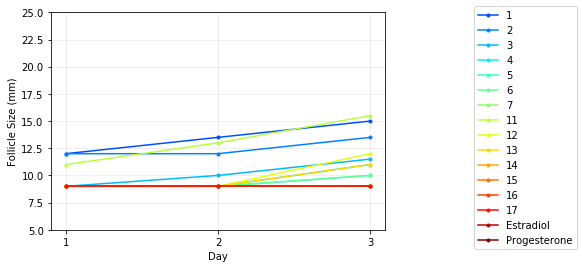

In [163]:
from matplotlib import cm

def color_picker(start, end, num_lines):
    
    cm_subsection = np.linspace(start, end, num_lines)
    colors = [cm.jet(x) for x in cm_subsection]
    return colors

def plot_data(df, xlabel, ylabel):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, ylabel=ylabel)
    
    colors = color_picker(0.2, 1.0, 16)

    column_names = data.columns.tolist()
    xs_names = data.index.tolist()
    xs = np.array([1,2,3])

    for i, col in enumerate(column_names):
        if i < 16:
            ax1.plot(xs, data[col], color=colors[i], linestyle='-', marker='.')
    
    ticks = np.arange(1,4,1)
    ax1.set_xticks(ticks)
    plt.xlabel(xlabel)
    ax1.set_ylim(5,25)
    ax1.grid(alpha=0.25)
    ax1.legend(bbox_to_anchor=(1.25, 1.05))
    
plot_data(data, 'Day', 'Follicle Size (mm)')
save_to = '/Users/Kristen/Documents/Baby_Making/Follicle_Growth.jpeg'
plt.savefig(save_to)
plt.show()
    

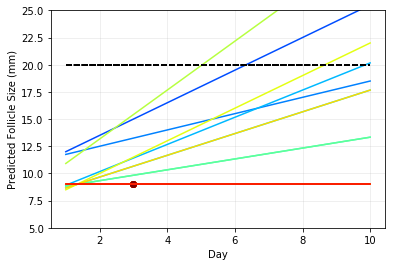

In [164]:
from sklearn import linear_model

def drop_cols_with_nan(df):
    df.dropna(axis=1, how='any', inplace=True)
    return df

def predict_future(df, xs, start_day, end_day, cut_off):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    predict_xs = np.arange(start_day, end_day, 1)
    
    data_train = drop_cols_with_nan(data)
    column_names = data_train.columns.tolist()
    for i, col in enumerate(column_names):
        if i < 16:
            lin_regr = linear_model.LinearRegression()
            y_data = np.asarray(data_train[col])
            lin_regr.fit(np.transpose(np.matrix(xs)), np.transpose(np.matrix(y_data)))
            ax = plot_predictions(xs, y_data, predict_xs, lin_regr, i, ax1)
            plot_cutoff(cut_off, predict_xs, ax)
    return ax

def plot_predictions(xs, y_train, predict_xs, lin_regr, i, ax1):
    
    colors = color_picker(0.2, 1.0, 16)
    ax1.scatter(xs, y_data, color=colors[i])
    ax1.plot(predict_xs, lin_regr.predict(np.transpose(np.matrix(predict_xs))), color=colors[i])
    ax1.set_ylim(5,25)
    ax1.set_ylabel('Predicted Follicle Size (mm)')
    ax1.set_xlabel('Day')
    ax1.grid(alpha=0.25)
    return ax1

def plot_cutoff(cut_off, predict_xs, ax):
    line = [cut_off]*len(predict_xs)
    ax.plot(predict_xs, line, color='k', linestyle='--')      


ax = predict_future(data, xs, 1, 11, 20)
ax.legend(bbox_to_anchor=(1.25, 1.05))
    
save_to = '/Users/Kristen/Documents/Baby_Making/Predicted_Follicle_Growth.jpeg'
plt.savefig(save_to)
plt.show()
